In [1]:
#Importación de librearías necesarias
import pandas as pd
from datetime import datetime
import socket
import numpy as np
import math
import time
import pickle  #Para guardar archivos
import os
os.environ['OMP_NUM_THREADS'] = '1'

from pympler import asizeof #Para liberar memoria
import gc

import matplotlib.pyplot as plt

from kneed import KneeLocator 
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [2]:
#Path general de archivos
if socket.gethostname()=='LAPTOP-PUSGG08B': #Ip de la laptop
    ruta = "E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/Data/TFM/"
    r_ruta = "E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/RData/TFM/"
    r_graf = 'E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/Reportes/'
elif socket.gethostname()=='PCUIOMTDAIE6382': #Ip del working
    ruta =   "D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/Data/TFM/"
    r_ruta = "D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/RData/TFM/"
    r_graf = 'D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/Reportes/'
# Ruta del archivo de pensionistas de vejez
ruta_vj = ruta + 'POB_VEJ_CD656_NEW.dsv'
# Ruta del archivo de historia laboral de pensionistas
ruta_afi = ruta + 'APORTES_CD656_new.dsv'

In [3]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_clean_afi_sel_g_all_2.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)
data_l = pd.read_pickle(ruta_archivo)

KeyboardInterrupt: 

In [ ]:
inicio = time.time()
data_l = data_l.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[ True, True, True] )
data_l.reset_index(inplace=True)
data_l.rename(columns={'index': 'nuevo_indice'}, inplace=True)
data_l.drop(columns=['nuevo_indice'], inplace=True)
data_l['INDICE'] = data_l.index
data_l['LS_MS'] = np.nan

#Casos de no análisis
data_no_grupo = data_l[ (data_l['GRUPO_SEL']==0) ].copy()
data_no_grupo['ATI_DB'] = np.nan
data_no_grupo['EPS'] = np.nan
data_no_grupo['MINPTS'] = np.nan

#Casos de análisis
data = data_l[ (data_l['GRUPO_SEL']==1) ].copy()

fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

In [ ]:
#Se calculo los bigotes superiores para toda la historia laboral
inicio = time.time() 
dataa = data_l.copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['SAL_PROM1'] =  np.nanmean(salarios)
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': [], 'SAL_PROM1': [] }

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )
    data1['SAL_PROM1'].append( val['SAL_PROM1'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[:, 'LS1'] = data_l['CEDULA_COD'].map(LS)

SPROM = pd.DataFrame( data1 )
SPROM = SPROM.groupby('CEDULA_COD')['SAL_PROM1'].first()
data_l.loc[:, 'SAL_PROM1'] = data_l['CEDULA_COD'].map(SPROM)

del dataa, data1, dic_aux, LS, salarios, SPROM
gc.collect()

##Se calculo los bigotes superiores para toda la historia laboral, a partir del año 2000 en adelante.
dataa = data_l[data_l['ANIO']>=2000].copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['SAL_PROM2'] =  np.nanmean(salarios)
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': [], 'SAL_PROM2': []  }

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )
    data1['SAL_PROM2'].append( val['SAL_PROM2'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[:, 'LS2'] = data_l['CEDULA_COD'].map(LS)

SPROM = pd.DataFrame( data1 )
SPROM = SPROM.groupby('CEDULA_COD')['SAL_PROM2'].first()
data_l.loc[:, 'SAL_PROM2'] = data_l['CEDULA_COD'].map(SPROM)

del dataa, data1, dic_aux, LS, salarios, SPROM
gc.collect()

fin = time.time()  
print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos')

In [ ]:
#Algortimos DBSCAN
cedula_1 = data.groupby('CEDULA_COD')['NUM_SEC_MES'].apply( lambda x: (x != 1).any() )
cedula_dist = cedula_1[ cedula_1 ].index
ul = data[ ~data['CEDULA_COD'].isin( cedula_dist )]
ml = data[  data['CEDULA_COD'].isin( cedula_dist )]

In [ ]:
#Se calculo los bigotes superiores para la historia laboral de los mejores años
inicio = time.time() 
dataa = ul.copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': []}

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[ ~data_l['CEDULA_COD'].isin( cedula_dist ), 'LS_MS'] = data_l['CEDULA_COD'].map(LS)

del dataa, data1, dic_aux, LS
gc.collect()

dataa = ml.copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': []}

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[  data_l['CEDULA_COD'].isin( cedula_dist ), 'LS_MS'] = data_l['CEDULA_COD'].map(LS)

del dataa, data1, dic_aux, LS
gc.collect()

In [ ]:
ul_dic = ul.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
ml_dic = ml.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')

In [ ]:
ul_dic[230]

In [ ]:
def valor_epsilon( data, val ):
    
    for ced in data:
        aux = None
        aux = np.array( data[ced][val] ).reshape(-1, 1)
        eps = []
        minpt = []
        data[ced]['eps'] = []
        data[ced]['min_pt'] = []

        for i in range(1, 12):
            vecinos = NearestNeighbors( n_neighbors = min( i, len(aux) ) + 1  )
            vecinos_ajustado = vecinos.fit( aux )
            distancias = vecinos_ajustado.kneighbors(aux )[0]
            distancias1 = distancias[:, 1:]
            distancias_ordenadas = np.sort(distancias1.ravel())

            if len( np.unique( distancias_ordenadas ) )==1:
                eps.append( 0.0 )
                minpt.append( i + 1 )

            if len( np.unique( distancias_ordenadas ) )!=1:
                codo = KneeLocator(np.arange(len(distancias_ordenadas)), distancias_ordenadas, curve="convex", direction="increasing")

                eps.append( distancias_ordenadas[codo.elbow])
                minpt.append( i + 1 )

        for i, eps in enumerate( eps ):
            if eps not in data[ced]['eps']:
                data[ced]['eps'].append( eps )
                data[ced]['min_pt'].append( minpt[i] )
    

In [ ]:
inicio = time.time()
valor_epsilon(ul_dic, 'SALARIO')
valor_epsilon(ml_dic, 'SALARIO')
fin = time.time()  
print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

In [ ]:
#Se guardan los resultados 
nombre_archivo = 'viu_db_ul.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto1 = ul_dic

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto1, archivo) 
    
nombre_archivo = 'viu_db_ml.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto2 = ml_dic

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto2, archivo)  

In [4]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_db_ul.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)
ul_dic = pd.read_pickle(ruta_archivo)

directorio = r_ruta
nombre_archivo = 'viu_db_ml.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)
ml_dic = pd.read_pickle(ruta_archivo)

In [5]:
def rangos_valores(number):
    actions = {
        (0, 1): 2,
        (1, 2): 1,
        (2, 3): 2,
        (3, 4): 3,
        (4, 5): 4,
        (5, float('inf')): 5
    }
    
    for (start, end), (val1) in actions.items():
        if start < number <= end:
            return val1 
        
def esti_eps_out( data_dic, val ):
    
    for ced in data_dic:
        aux =  np.array( data_dic[ced][val] ).reshape(-1, 1)
        ep = data_dic[ced]['eps']
        mt = data_dic[ced]['min_pt']

        n_clusters = []
        n_outliers = []
        v_e = []
        g_e = []
        n_e = []

        for j in range(0, len(ep) ):

            if  ep[ j ] <= 0.1:
                n_clusters.append( -1 )
                n_outliers.append( -1 )
                v_e.append( ep[ j ] )
                g_e.append( j )
                n_e.append( mt[j] )
            
            else:
                var1 = rangos_valores(ep[ j ])
                ini =  max(0.1, ep[ j ] - var1 )
                for eps in np.linspace(ini, ep[ j ], 6):
                        labels=None
                        db = DBSCAN( eps, min_samples = mt[j] ).fit( aux )
                        core_samples_mask = np.zeros_like( db.labels_, dtype=bool)
                        core_samples_mask[db.core_sample_indices_] = True
                        labels = db.labels_
                        n_clusters.append( len(set(labels)) - (1 if -1 in labels else 0) )
                        n_outliers.append( list(labels).count(-1) )
                        v_e.append( eps ) 
                        g_e.append( j )
                        n_e.append( mt[j] )
 
        ag = np.empty((len(v_e) , 5))   
        ag[ :, 0 ] = g_e
        ag[ :, 1 ] = v_e
        ag[ :, 2 ] = n_e
        ag[ :, 3 ] = n_clusters
        ag[ :, 4 ] = n_outliers
        data_dic[ced]['esti_eps_out'] = ag


In [6]:
inicio = time.time()
print('*' * 102)
print('Determinación del número de clúster  y número atípicos')
val='SALARIO'
esti_eps_out( ul_dic, val )
esti_eps_out( ml_dic, val )
fin = time.time()  
print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

******************************************************************************************************
Determinación del número de clúster  y número atípicos


KeyboardInterrupt: 

In [ ]:
#Seleccionar el valor de epsilon y los atipicos
def cal_eps_out( data_dic ):
    for ced in data_dic:
        aux = data_dic[ced]['esti_eps_out']
        aux1 =  np.array( data_dic[ced]['SALARIO'] ).reshape(-1, 1)
        col1 = 4
        col2 = 3

        # Encontrar el valor máximo en la columna 4 (índice 3)
        val1 = np.max(aux[:,  col1])

        # Filtrar las filas que tienen el valor máximo en la columna 4
        fil= aux[aux[:, col1] == val1]

        # Encontrar la fila con el menor valor en la columna 3 (índice 2) entre las filas filtradas
        indice = np.argmin( fil[:, col2 ])

        # Seleccionar la fila correspondiente
        fila_max_min =  fil[ indice]
        data_dic[ced]['eps_c'] = fila_max_min[1]
        data_dic[ced]['mpt_c'] = fila_max_min[2]
        
        if fila_max_min[1] ==0:
            data_dic[ced]['ATI_DB'] = [-1] * ( len(aux1) )
        else:
            db = DBSCAN( eps = fila_max_min[1], min_samples = int(fila_max_min[2]) ).fit( aux1 )
            data_dic[ced]['ATI_DB'] = (db.labels_).tolist()
        

In [ ]:
inicio = time.time()
print('*' * 102)
print('Determinación del número de clúster  y número atípicos')
val='SALARIO'
cal_eps_out( ul_dic )
cal_eps_out( ml_dic )
fin = time.time()  
print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

In [ ]:
ul_dic

In [ ]:
#Extensión a dataframe
def extend_data( data_val_ati ):
    inicio = time.time()
    print('Extensión a dataframe de los diccionarios')
    data1 = { 'CEDULA_COD': [], 'SALARIO': [], 'INDICE':[], 'ATI_DB':[], 'EPS':[], 'MINPTS':[]}

    # Llenar las listas con los datos del diccionario
    for cedula, values in data_val_ati.items():
        salario = values['SALARIO']
        indice = values['INDICE']
        atipico= values['ATI_DB']
        ep = values['eps_c']
        mt = values['mpt_c']
        num_rows = len(salario)

        # Extender las listas en el diccionario de datos
        data1['CEDULA_COD'].extend( [cedula] * num_rows )
        data1['SALARIO'].extend( salario )
        data1['ATI_DB' ].extend( atipico )
        data1['INDICE'].extend( indice )
        data1['EPS'].extend( [ep] * num_rows )
        data1['MINPTS'].extend( [mt] * num_rows  )

    data1 = pd.DataFrame( data1 )
    
    fin = time.time()  
    print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
    return(data1)

In [ ]:
def union_dic( data, data_no_grupo, data_dic1, data_dic2):
    inicio = time.time()
    print('*' * 102)
    print('Concatenación con el dataframe original') 
    data1 = extend_data( data_dic1 ) 
    data2 = extend_data( data_dic2 ) 

    data_db = pd.concat( [ data_no_grupo[['CEDULA_COD', 'SALARIO', 'ATI_DB', 'EPS', 'MINPTS','INDICE']],
                                   data1[['CEDULA_COD', 'SALARIO', 'ATI_DB', 'EPS', 'MINPTS','INDICE']],
                                   data2[['CEDULA_COD', 'SALARIO', 'ATI_DB', 'EPS', 'MINPTS','INDICE']]], axis=0)

    data_db = data_db.sort_values( by = ["INDICE"], ascending = [ True ] )
    data_db.reset_index( inplace = True )
    data_db.rename( columns = {'index': 'nuevo_indice'}, inplace = True )
    data_db.drop( columns = ['nuevo_indice'], inplace=True )

    col = ['ATI_DB','EPS', 'MINPTS']
    data[ col ] = np.nan

    for nom_col in col:
        aux = None
        aux = data_db[ nom_col ].to_numpy()
        data.iloc[:, data.columns.get_loc( nom_col )] = aux
    
    del data1, data2, data_db
    gc.collect()
    #return(data_db)
       
    fin = time.time()  
    tm = (fin-inicio)
    print('\tTiempo de ejecución es: ', tm//3600, ' horas con ' , tm%3600//60 , ' minutos y', tm%60, ' segundos' )

In [ ]:
union_dic( data_l, data_no_grupo, ul_dic, ml_dic)

In [ ]:
filtered_data = data_l[data_l['SALARIO'] != a['SALARIO']]

# Mostrar las filas donde 'SALARIO' no coincide
print(filtered_data)

In [ ]:
#Se guardan resultados
nombre_archivo = 'viu_db_ul_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto1 = ul_dic

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto1, archivo) 
    
nombre_archivo = 'viu_db_ml_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto2 = ml_dic

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto2, archivo) 
    
nombre_archivo = 'viu_db_data_l_cl.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto3 = data_l

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto3, archivo) 
    
del objeto1, objeto2, objeto3
gc.collect()

In [9]:
#Desde esta parte comienza la corrección de datos
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_db_data_l_cl.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)
data_l = pd.read_pickle(ruta_archivo)

# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_db_ul_ati.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)
ul_dic = pd.read_pickle(ruta_archivo)

# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_db_ml_ati.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)
ml_dic = pd.read_pickle(ruta_archivo)

In [15]:
claves_eps_c_igual_0 = [clave for clave, valores in ul_dic.items() if isinstance(valores, dict) and valores.get('eps_c') == 0]
claves_eps_c_igual_0

[426,
 942,
 1429,
 2433,
 2512,
 2540,
 2849,
 3578,
 4546,
 5147,
 6037,
 6694,
 8851,
 8889,
 9315,
 9548,
 9622,
 9671,
 9804,
 10037,
 10272,
 10346,
 10397,
 10419,
 10572,
 10588,
 10785,
 10866,
 10908,
 11053,
 11124,
 11206,
 11282,
 11368,
 11449,
 11491,
 11574,
 11579,
 11648,
 11659,
 11792,
 11983,
 12077,
 12120,
 12273,
 12279,
 12282,
 12289,
 12326,
 12331,
 12360,
 12413,
 12584,
 12713,
 12804,
 12819,
 12891,
 12915,
 13038,
 13050,
 13059,
 13087,
 13092,
 13158,
 13192,
 13220,
 13248,
 13262,
 13276,
 13293,
 13305,
 13320,
 13323,
 13349,
 13394,
 13417,
 13622,
 13764,
 13849,
 14196,
 14226,
 14247,
 14288,
 14363,
 14789,
 14810,
 14854,
 14891,
 14960,
 15006,
 15017,
 15422,
 15448,
 15509,
 15535,
 15571,
 15704,
 15748,
 15792,
 15913,
 15952,
 15957,
 15961,
 16142,
 16418,
 16973,
 17598,
 17681,
 17685,
 17839,
 17948,
 17988,
 18002,
 18027,
 18063,
 18079,
 18165,
 18169,
 18192,
 18271,
 18320,
 18321,
 18341,
 18369,
 18373,
 18382,
 18395,
 1840

In [16]:
ul_dic[426]

{'SALARIO': [390.59,
  390.59,
  390.59,
  390.59,
  390.59,
  390.59,
  390.59,
  390.59,
  390.59,
  390.59,
  390.59,
  390.59,
  390.59,
  390.59,
  402.08,
  402.08,
  402.08,
  402.08,
  402.08,
  402.08,
  402.08,
  402.08,
  402.08,
  402.08,
  402.08,
  402.08,
  410.41,
  410.41,
  410.41,
  410.41,
  410.41,
  410.41,
  410.41,
  410.41,
  410.41,
  410.41,
  410.41,
  410.41,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66,
  416.66],
 'INDICE': [1415,
  1416,
  1417,
  1418,
  1419,
  1420,
  1421,
  1422,
  1423,
  1424,
  1425,
  1426,
  1427,
  1428,
  1429,
  1430,
  1431,
  1432,
  1433,
  1434,
  1435,
  1436,
  1437,
  1438,
  1439,
  1440,
  1441,
  1442,
  1443,
  1444,
  1445,
  1446,
  1447,
  1448,
  1449,
  1450,
  1451,
  1452,
  1453,
  1454,
  1455,
  1456,
  1457,
  1458,
  1459,
  1460,
  1461,
  

In [ ]:
grouped = data_l['CEDULA_COD'].drop_duplicates().sample(n=20000, random_state=1)
muestra = data_l[data_l['CEDULA_COD'].isin(grouped)]
muestra.to_csv('muestra_db.txt', sep='\t', index=False)# Agrupar por CEDULA_COD

In [17]:
#Comprobación de la clasificación del dbscan
inicio = time.time()
#Se trabaja primero con las cédulas que tienen un único sector
data = data_l[data_l['GRUPO_SEL']==1]
nodata = data_l[data_l['GRUPO_SEL']==0]
del data_l
gc.collect()

fin = time.time()  
tm=fin-inicio
print('\tTiempo de ejecución es: ',  tm//3600, ' horas con ' ,  tm%3600//60 , ' minutos y', tm%60, ' segundos' )

	Tiempo de ejecución es:  0.0  horas con  1.0  minutos y 44.47008919715881  segundos


In [18]:
inicio = time.time()
cedula_1 = data.groupby('CEDULA_COD')['NUM_SEC_MES'].apply( lambda x: (x != 1).any() )
cedula_dist = cedula_1[ cedula_1 ].index
ul = data[ ~data['CEDULA_COD'].isin( cedula_dist )]
ml = data[  data['CEDULA_COD'].isin( cedula_dist )]
fin = time.time()  
print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

	Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 43.23700761795044  segundos


In [19]:
#Se analiza los casos con únicos sectores
print('Cédulas en ul', ul['CEDULA_COD'].nunique()) 
print('Cédulas en ml', ml['CEDULA_COD'].nunique()) 

Cédulas en ul 373069
Cédulas en ml 69501


In [22]:
ul.head(5)

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,ID_SBU,INDICE,LS_MS,LS1,SAL_PROM1,LS2,SAL_PROM2,ATI_DB,EPS,MINPTS
13,126,2006,1,161.67,161.67,PRI,1,1,5,161.67,...,-1,13,370.0,382.495,201.720411,382.495,201.720411,0.0,148.61,4.0
14,126,2006,2,161.67,161.67,PRI,1,1,5,161.67,...,-1,14,370.0,382.495,201.720411,382.495,201.720411,0.0,148.61,4.0
15,126,2006,3,161.67,161.67,PRI,1,1,5,161.67,...,-1,15,370.0,382.495,201.720411,382.495,201.720411,0.0,148.61,4.0
16,126,2006,4,161.67,161.67,PRI,1,1,5,161.67,...,-1,16,370.0,382.495,201.720411,382.495,201.720411,0.0,148.61,4.0
17,126,2006,5,161.67,161.67,PRI,1,1,5,161.67,...,-1,17,370.0,382.495,201.720411,382.495,201.720411,0.0,148.61,4.0


In [25]:
 ul[(ul['EPS']==0)]['CEDULA_COD'].unique()

array([     426,      942,     1429, ..., 20856876, 20878541, 20889867],
      dtype=int64)

In [26]:
ul[ul['CEDULA_COD']==426]

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,ID_SBU,INDICE,LS_MS,LS1,SAL_PROM1,LS2,SAL_PROM2,ATI_DB,EPS,MINPTS
1415,426,2016,11,390.59,390.59,IND,1,1,5,390.590000,...,-1,1415,438.53,440.14,398.361967,440.14,398.361967,-1.0,0.0,2.0
1416,426,2016,12,390.59,390.59,IND,1,1,5,390.590000,...,-1,1416,438.53,440.14,398.361967,440.14,398.361967,-1.0,0.0,2.0
1417,426,2017,1,390.59,390.59,IND,1,1,5,390.590000,...,-1,1417,438.53,440.14,398.361967,440.14,398.361967,-1.0,0.0,2.0
1418,426,2017,2,390.59,390.59,IND,1,1,5,390.590000,...,-1,1418,438.53,440.14,398.361967,440.14,398.361967,-1.0,0.0,2.0
1419,426,2017,3,390.59,390.59,IND,1,1,5,390.590000,...,-1,1419,438.53,440.14,398.361967,440.14,398.361967,-1.0,0.0,2.0
1420,426,2017,4,390.59,390.59,IND,1,1,5,390.590000,...,-1,1420,438.53,440.14,398.361967,440.14,398.361967,-1.0,0.0,2.0
1421,426,2017,5,390.59,390.59,IND,1,1,5,390.590000,...,-1,1421,438.53,440.14,398.361967,440.14,398.361967,-1.0,0.0,2.0
1422,426,2017,6,390.59,390.59,IND,1,1,5,390.590000,...,-1,1422,438.53,440.14,398.361967,440.14,398.361967,-1.0,0.0,2.0
1423,426,2017,7,390.59,390.59,IND,1,1,5,390.590000,...,-1,1423,438.53,440.14,398.361967,440.14,398.361967,-1.0,0.0,2.0
1424,426,2017,8,390.59,390.59,IND,1,1,5,390.590000,...,-1,1424,438.53,440.14,398.361967,440.14,398.361967,-1.0,0.0,2.0


In [27]:
#Se analiza los casos con únicos sectores
print('Cédulas con un único sector que tienen al menos un atípico', ul[ (ul['ATI_DB']==-1) & (ul['EPS']!=0)]['CEDULA_COD'].nunique()) #316552
print('Cédulas con múltiples sectores que tienen al menos un atípico', ml[ (ml['ATI_DB']==-1) & (ml['EPS']!=0)]['CEDULA_COD'].nunique()) #68596

Cédulas con un único sector que tienen al menos un atípico 316552
Cédulas con múltiples sectores que tienen al menos un atípico 68596


In [7]:
print('*' * 40, 'Cédulas con sectores únicos', '*' * 40)
print('\tCedulas que tienen un único sector y que fue clasificado como no atipico, que se modificaran a  atipico:',
ul[ (ul['ATI_DB'] != -1) & (ul['SALARIO'] > ul['LS2'])]['CEDULA_COD'].nunique()) 
print('\tCedulas que tienen un único sector y que fue clasificado como atipico, que se modificaran a  no atipico:',
ul[ (ul['ATI_DB'] == -1) & (ul['SALARIO'] <= ul['SBU'])]['CEDULA_COD'].nunique())       

**************************************** Cédulas con sectores únicos ****************************************
	Cedulas que tienen un único sector y que fue clasificado como no atipico, que se modificaran a  atipico: 29111
	Cedulas que tienen un único sector y que fue clasificado como atipico, que se modificaran a  no atipico: 128704


In [ ]:
ul[ul['CEDULA_COD']==13603]

In [ ]:
ul[ (ul['ATI_DB'] == 1) & (ul['SALARIO'] < ul[['LS2', 'LS_MS']].min(axis=1) ) ] 

In [17]:
def graf_dbscan(data_i, ced, val, grupo_sel = 0):
    #Adecuación de la base de datos
    idx = data_i.columns.get_loc('LS_MS')
    columnas_requeridas = ['CEDULA_COD', 'ANIO', 'MES', val, 'GRUPO_SEL', 'INDICE', 'BASE_CAL'] + list(data_i.columns[idx:])
    data = data_i[data_i['CEDULA_COD'] == ced][columnas_requeridas]
    
    # Establecer si se quieren todos o solos los 5 mejores años
    if(grupo_sel == 1):
        data = data[data['GRUPO_SEL']==1]
    
    #Fecha para eje x
    anios = data['ANIO'].tolist()
    meses = data['MES'].tolist()
    fechas = [datetime(year=anio, month=mes, day=1) for anio, mes in zip(anios, meses)]
    data['FECHA']= pd.to_datetime(fechas)
    data = data.sort_values(by='FECHA')
    
    #Paleta de colores
    colors = plt.get_cmap('tab20').colors

    # Gráfico
    plt.figure(figsize=(12, 8))  
    marker_dict = {1: 'o', 2: 'x'} 
    
    data_aux = data[data['GRUPO_SEL']==1]
    if grupo_sel == 0: 
        Grupo_b= data[(data['GRUPO_SEL'] == 0)]
        plt.scatter(Grupo_b['FECHA'], Grupo_b[val], marker= '^', color='yellow', label='Valores no considerados')
        
        for i in np.sort(data_aux['ATI_DB'].unique()):
            if i == -1:
                Grupo_a = data_aux[data_aux['ATI_DB'] == -1]
                plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= 'x', color='red', label='Valores Atípicos')

            else:
                color = colors[int(i % len(colors))]
                Grupo= data_aux[data_aux['ATI_DB'] == i]
                plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= color, label=f'Clúster {int(i + 1)}')
                
    else:
        for i in np.sort(data['ATI_DB'].unique()):
            if i == -1:
                Grupo_a = data[data['ATI_DB'] == -1]
                plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= 'x', color='red', label='Valores Atípicos')

            else:
                color = colors[int(i % len(colors))]
                Grupo= data[data['ATI_DB'] == i]
                plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= color, label=f'Clúster {int(i + 1)}')
    
    plt.axhline(y= data['SAL_PROM2'].iloc[0], color= '#1297ff', linestyle='-', label='Promedio Salarios')
    plt.axhline(y=data['LS2'].iloc[0], alpha=1 , color= '#25ce00', linestyle='--', label='LS2')
    plt.axhline(y=data_aux['LS_MS'].iloc[0], alpha=1, color= '#875b20', linestyle='--', label='LS_MS')
    plt.axhline(y=data['BASE_CAL'].iloc[0], alpha=1, color= '#E800FF', linestyle=':', label='Base de cálculo')
    
    # Añadir el número de clusters, EPS, MINPTS
    plt.scatter( data_aux['FECHA'].iloc[0], data_aux[val].iloc[0], facecolors='none', label="Número de clústers: {}".format(int(max(data_aux['ATI_DB'].unique()) + 1)))
    plt.scatter( data_aux['FECHA'].iloc[0], data_aux[val].iloc[0], facecolors='none', label="Épsilon: {}".format(round(data_aux['EPS'].iloc[0], 2)))
    plt.scatter( data_aux['FECHA'].iloc[0], data_aux[val].iloc[0], facecolors='none', label="Min Pts: {}".format(int(data_aux['MINPTS'].iloc[0])))
    
    # Añadir títulos y etiquetas
    plt.title(f"Aportaciones de la cédula: {ced}")
    plt.xlabel('FECHA')
    plt.ylabel(f"{val}")
    
    # Crear la leyenda
    leyenda = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    plt.grid(True)
    plt.show()
    
def graf_dbscan_guardar(data_i, ced, val, grupo_sel = 0, caso=1):
    #Adecuación de la base de datos
    idx = data_i.columns.get_loc('LS_MS')
    columnas_requeridas = ['CEDULA_COD', 'ANIO', 'MES', val, 'GRUPO_SEL', 'INDICE', 'BASE_CAL'] + list(data_i.columns[idx:])
    data = data_i[data_i['CEDULA_COD'] == ced][columnas_requeridas]
    
    # Establecer si se quieren todos o solos los 5 mejores años
    if(grupo_sel == 1):
        data = data[data['GRUPO_SEL']==1]
    
    #Fecha para eje x
    anios = data['ANIO'].tolist()
    meses = data['MES'].tolist()
    fechas = [datetime(year=anio, month=mes, day=1) for anio, mes in zip(anios, meses)]
    data['FECHA']= pd.to_datetime(fechas)
    data = data.sort_values(by='FECHA')
    
    #Paleta de colores
    colors = plt.get_cmap('tab20').colors

    # Gráfico
    plt.figure(figsize=(12, 8))  
    marker_dict = {1: 'o', 2: 'x'} 
    
    data_aux = data[data['GRUPO_SEL']==1]
    if grupo_sel == 0: 
        Grupo_b= data[(data['GRUPO_SEL'] == 0)]
        plt.scatter(Grupo_b['FECHA'], Grupo_b[val], marker= '^', color='yellow', label='Valores no considerados')
        
        for i in np.sort(data_aux['ATI_DB'].unique()):
            if i == -1:
                Grupo_a = data_aux[data_aux['ATI_DB'] == -1]
                plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= 'x', color='red', label='Valores Atípicos')

            else:
                color = colors[int(i % len(colors))]
                Grupo= data_aux[data_aux['ATI_DB'] == i]
                plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= color, label=f'Clúster {int(i + 1)}')
                
    else:
        for i in np.sort(data['ATI_DB'].unique()):
            if i == -1:
                Grupo_a = data[data['ATI_DB'] == -1]
                plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= 'x', color='red', label='Valores Atípicos')

            else:
                color = colors[int(i % len(colors))]
                Grupo= data[data['ATI_DB'] == i]
                plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= color, label=f'Clúster {int(i + 1)}')
    
    plt.axhline(y= data['SAL_PROM2'].iloc[0], color= '#1297ff', linestyle='-', label='Promedio Salarios')
    plt.axhline(y=data['LS2'].iloc[0], alpha=1 , color= '#25ce00', linestyle='--', label='LS2')
    plt.axhline(y=data_aux['LS_MS'].iloc[0], alpha=1, color= '#875b20', linestyle='--', label='LS_MS')
    plt.axhline(y=data['BASE_CAL'].iloc[0], alpha=1, color= '#E800FF', linestyle=':', label='Base de cálculo')
    
    # Añadir el número de clusters, EPS, MINPTS
    plt.scatter( data_aux['FECHA'].iloc[0], data_aux[val].iloc[0], facecolors='none', label="Número de clústers: {}".format(int(max(data_aux['ATI_DB'].unique()) + 1)))
    plt.scatter( data_aux['FECHA'].iloc[0], data_aux[val].iloc[0], facecolors='none', label="Épsilon: {}".format(round(data_aux['EPS'].iloc[0], 2)))
    plt.scatter( data_aux['FECHA'].iloc[0], data_aux[val].iloc[0], facecolors='none', label="Min Pts: {}".format(int(data_aux['MINPTS'].iloc[0])))
    
    # Añadir títulos y etiquetas
    plt.title(f"Aportaciones de la cédula: {ced}")
    plt.xlabel('FECHA')
    plt.ylabel(f"{val}")
    
    # Crear la leyenda
    leyenda = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    plt.grid(True)
    plt.savefig( r_graf + 'algoritmo_db_'+str(ced)+'_'+ str(caso)+'.png' )

#Para graficar el comportamiento de los atipicos
def graf_DB(data_i, ced, val, grupo_sel = 0):
    #Adecuación de la base de datos
    idx = data_i.columns.get_loc('ATI_DB')
    columnas_requeridas = ['CEDULA_COD', 'ANIO', 'MES', val, 'GRUPO_SEL', 'INDICE', 'BASE_CAL'] + list(data_i.columns[idx:])
    data = data_i[data_i['CEDULA_COD'] == ced][columnas_requeridas]
    
    # Establecer si se quieren todos o solos los 5 mejores años
    if(grupo_sel == 1):
        data = data[data['GRUPO_SEL']==1]
    
    #Fecha para eje x
    anios = data['ANIO'].tolist()
    meses = data['MES'].tolist()
    fechas = [datetime(year=anio, month=mes, day=1) for anio, mes in zip(anios, meses)]
    data['FECHA']= pd.to_datetime(fechas)
    data = data.sort_values(by='FECHA')
    
    #Paleta de colores
    colors = plt.get_cmap('tab20').colors

    # Gráfico
    plt.figure(figsize=(12, 8))  
    marker_dict = {1: 'o', 2: 'x'} 
    
    data_aux = data[data['GRUPO_SEL']==1]
    if grupo_sel == 0: 
        Grupo_b= data[(data['GRUPO_SEL'] == 0)]
        plt.scatter(Grupo_b['FECHA'], Grupo_b[val], marker= '^', color='yellow', label='Valores no considerados')
        
        if 0 in (data_aux['ATI_DB'].unique()):
            Grupo_a = data_aux[data_aux['ATI_DB'] == 0]
            plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= marker_dict[1], color='blue', label='Valores No Atípicos : 0')

        if 1 in (data_aux['ATI_DB'].unique()):
            Grupo= data_aux[data_aux['ATI_DB'] == 1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'red', label='Valores Atípicos : 1')
            
        if -1 in (data_aux['ATI_DB'].unique()):
            Grupo= data_aux[data_aux['ATI_DB'] == -1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'green', label='Clúster único')
                
    else:
        if 0 in (data['ATI_DB'].unique()):
            Grupo_a = data[data['ATI_DB'] == 0]
            plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= marker_dict[1], color='blue', label='Valores No Atípicos : 0')

        if 1 in (data['ATI_DB'].unique()):
            Grupo= data[data['ATI_DB'] == 1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'red', label='Valores Atípicos : 1')
            
        if -1 in (data['ATI_DB'].unique()):
            Grupo= data[data['ATI_DB'] == -1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'green', label='Clúster único')
        
    
    plt.axhline(y= data['SAL_PROM2'].iloc[0], color= '#1297ff', linestyle='-', label='Promedio Salarios')
    plt.axhline(y=data['LS2'].iloc[0], alpha=1 , color= '#25ce00', linestyle='--', label='LS2')
    plt.axhline(y=data_aux['LS_MS'].iloc[0], alpha=1, color= '#875b20', linestyle='--', label='LS_MS')
    plt.axhline(y=data['BASE_CAL'].iloc[0], alpha=1, color= '#E800FF', linestyle=':', label='Base de cálculo')
    
    # Añadir el número de clusters, EPS, MINPTS
    plt.scatter( data_aux['FECHA'].iloc[0], data_aux[val].iloc[0], facecolors='none', label="Número de clústers: {}".format(int(max(data_aux['ATI_DB'].unique()) + 1)))
    
    # Añadir títulos y etiquetas
    plt.title(f"Aportaciones de la cédula: {ced}")
    plt.xlabel('FECHA')
    plt.ylabel(f"{val}")
    
    # Crear la leyenda
    leyenda = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    plt.grid(True)
    plt.show()
    
def graf_DB_guardar(data_i, ced, val, grupo_sel = 0, caso=1):
    #Adecuación de la base de datos
    idx = data_i.columns.get_loc('ATI_DB')
    columnas_requeridas = ['CEDULA_COD', 'ANIO', 'MES', val, 'GRUPO_SEL', 'INDICE', 'BASE_CAL'] + list(data_i.columns[idx:])
    data = data_i[data_i['CEDULA_COD'] == ced][columnas_requeridas]
    
    # Establecer si se quieren todos o solos los 5 mejores años
    if(grupo_sel == 1):
        data = data[data['GRUPO_SEL']==1]
    
    #Fecha para eje x
    anios = data['ANIO'].tolist()
    meses = data['MES'].tolist()
    fechas = [datetime(year=anio, month=mes, day=1) for anio, mes in zip(anios, meses)]
    data['FECHA']= pd.to_datetime(fechas)
    data = data.sort_values(by='FECHA')
    
    #Paleta de colores
    colors = plt.get_cmap('tab20').colors

    # Gráfico
    plt.figure(figsize=(12, 8))  
    marker_dict = {1: 'o', 2: 'x'} 
    
    data_aux = data[data['GRUPO_SEL']==1]
    if grupo_sel == 0: 
        Grupo_b= data[(data['GRUPO_SEL'] == 0)]
        plt.scatter(Grupo_b['FECHA'], Grupo_b[val], marker= '^', color='yellow', label='Valores no considerados')
        
        if 0 in (data_aux['ATI_DB'].unique()):
            Grupo_a = data_aux[data_aux['ATI_DB'] == 0]
            plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= marker_dict[1], color='blue', label='Valores No Atípicos : 0')

        if 1 in (data_aux['ATI_DB'].unique()):
            Grupo= data_aux[data_aux['ATI_DB'] == 1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'red', label='Valores Atípicos : 1')
            
        if -1 in (data_aux['ATI_DB'].unique()):
            Grupo= data_aux[data_aux['ATI_DB'] == -1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'green', label='Clúster único')
                
    else:
        if 0 in (data['ATI_DB'].unique()):
            Grupo_a = data[data['ATI_DB'] == 0]
            plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= marker_dict[1], color='blue', label='Valores No Atípicos : 0')

        if 1 in (data['ATI_DB'].unique()):
            Grupo= data[data['ATI_DB'] == 1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'red', label='Valores Atípicos : 1')
            
        if -1 in (data['ATI_DB'].unique()):
            Grupo= data[data['ATI_DB'] == -1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'green', label='Clúster único')
        
    
    plt.axhline(y= data['SAL_PROM2'].iloc[0], color= '#1297ff', linestyle='-', label='Promedio Salarios')
    plt.axhline(y=data['LS2'].iloc[0], alpha=1 , color= '#25ce00', linestyle='--', label='LS2')
    plt.axhline(y=data_aux['LS_MS'].iloc[0], alpha=1, color= '#875b20', linestyle='--', label='LS_MS')
    plt.axhline(y=data['BASE_CAL'].iloc[0], alpha=1, color= '#E800FF', linestyle=':', label='Base de cálculo')
    
    # Añadir el número de clusters, EPS, MINPTS
    plt.scatter( data_aux['FECHA'].iloc[0], data_aux[val].iloc[0], facecolors='none', label="Número de clústers: {}".format(int(max(data_aux['ATI_DB'].unique()) + 1)))
    
    # Añadir títulos y etiquetas
    plt.title(f"Aportaciones de la cédula: {ced}")
    plt.xlabel('FECHA')
    plt.ylabel(f"{val}")
    
    # Crear la leyenda
    leyenda = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    plt.grid(True)
    plt.savefig( r_graf + 'algoritmo_db_ati_'+str(ced)+'_'+ str(caso)+'.png' )

In [ ]:
graf_dbscan(ul , 13603, 'SALARIO',  grupo_sel = 1)

In [8]:
#Corrección de los atípicos
ul.loc[ (ul['ATI_DB'] != -1) & (ul['SALARIO'] > ul['LS2']) , 'ATI_DB'] = -1
ul.loc[ (ul['ATI_DB'] == -1) & (ul['SALARIO'] < ul[['LS2', 'LS_MS']].min(axis=1) )  , 'ATI_DB'] = ul['ATI_DB'].max(skipna=True) + 1
ul.loc[ (ul['ATI_DB'] == -1) & (ul['SALARIO'] <= ul['SBU']) , 'ATI_DB'] = ul['ATI_DB'].max(skipna=True) + 1

ul.loc[ (ul['ATI_DB'] != -1), 'ATI_DB'] = 0
ul.loc[ (ul['ATI_DB'] == -1), 'ATI_DB'] = 1

In [ ]:
graf_dbscan(ul , 13603, 'SALARIO',  grupo_sel = 1)

In [9]:
#Cedulas que tiene datos atípicos luego de la corrección---------------------------------------------------------------------
print('\tCedulas con al menos un atípico con un único sector:', ul[ (ul['ATI_DB']==1) ]['CEDULA_COD'].nunique()) 

	Cedulas con al menos un atípico con un único sector: 157992


In [ ]:
ul[ul['ATI_DB']==1]['CEDULA_COD'].unique()

In [ ]:
ul[ul['CEDULA_COD']==13603]

In [10]:
dic_sim = ml.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'LS2':list,'LS_MS':list,'INDICE': list}).to_dict(orient='index')

for cedula in dic_sim:
    dic_sim[cedula]['SALARIO_SECTOR'] = [[float(val) for val in sal.split(';')] if isinstance(sal, str) else [sal] 
                                          for sal in dic_sim[cedula]['SALARIO_SECTOR']]

    min_ls = [min(ls2, ls_as) for ls2, ls_as in zip(dic_sim[cedula]['LS2'], dic_sim[cedula]['LS_MS'])]

    dic_sim[cedula]['ATI_DB_AS'] = [ 1 if any(sal > ls for sal in salarios) else 0 
                                    for salarios, ls in zip( dic_sim[cedula]['SALARIO_SECTOR'], min_ls )]

data1 = { 'CEDULA_COD': [], 'SALARIO_SECTOR': [], 
          'LS_MS' : [], 'ATI_DB_AS':[],  'INDICE':[]}

# Llenar las listas con los datos del diccionario
for cedula, values in dic_sim.items():
    salario = values['SALARIO_SECTOR']
    ls = values[ 'LS_MS' ]
    atipico = values[ 'ATI_DB_AS' ]
    indice = values['INDICE']
    num_rows = len(salario)

    # Extender las listas en el diccionario de datos
    data1['CEDULA_COD'].extend([cedula] * num_rows)
    data1['SALARIO_SECTOR'].extend(salario)
    data1['LS_MS' ].extend(ls)
    data1['ATI_DB_AS' ].extend(atipico)
    data1['INDICE'].extend(indice)

data1 = pd.DataFrame( data1 )
data1.set_index('INDICE', inplace=True )
cedul = list(dic_sim.keys())  #total de 111903
filtro = data1[ data1['CEDULA_COD'].isin(cedul )] # 111903 cedulas
indi = filtro.index
ml.loc[ indi, 'ATI_DB_AS'] = filtro['ATI_DB_AS']

del data1,  dic_sim, cedul, filtro, indi, salario, ls, atipico, indice, num_rows
gc.collect()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15636\3619269662.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml.loc[ indi, 'ATI_DB_AS'] = filtro['ATI_DB_AS']


0

In [ ]:
ml

In [11]:
#Corrección de los atípicos
ml.loc[ (ml['ATI_DB'] != -1) & (ml['SALARIO'] > ml['LS2']) , 'ATI_DB'] = -1
ml.loc[ (ml['ATI_DB'] == -1) & (ml['SALARIO'] <= ml['SBU']) , 'ATI_DB'] = ml['ATI_DB'].max(skipna=True) + 1

#Para cuando un valor de la suma de salarios es mayor al LS, como si fueran un solo aporte individual
ml.loc[(ml['ATI_DB'] == -1) & (ml['ATI_DB_AS'] == 0), 'ATI_DB'] = ml['ATI_DB_AS']
ml.loc[(ml['ATI_DB'] != -1) & (ml['ATI_DB_AS'] == 1), 'ATI_DB'] = -ml['ATI_DB_AS']

ml.loc[ (ml['ATI_DB'] != -1), 'ATI_DB'] = 0
ml.loc[ (ml['ATI_DB'] == -1), 'ATI_DB'] = 1

In [12]:
#Cedulas que tiene datos atípicos luego de la corrección---------------------------------------------------------------------
print('\tCedulas con al menos un atípico con múltiples sectores:', ml[ (ml['ATI_DB']==1) ]['CEDULA_COD'].nunique()) 

	Cedulas con al menos un atípico con múltiples sectores: 33943


In [ ]:
nodata

In [ ]:
nodata.columns

In [ ]:
ul.columns

In [ ]:
ml.columns

In [13]:
data_db = pd.concat( [ nodata, ul, ml ], axis=0 )

In [14]:
del nodata, ul, ml
gc.collect()

18

In [ ]:
data_db.head(10)

In [15]:
data_db = data_db.sort_values( by = ["INDICE"], ascending = [ True ] )
data_db.reset_index( inplace = True )
data_db.rename( columns = {'index': 'nuevo_indice'}, inplace = True )
data_db.drop( columns = ['nuevo_indice'], inplace=True )

In [16]:
nombre_archivo = 'viu_db_data_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto1 = data_db

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto1, archivo) 
    
del objeto1
gc.collect()


0

In [22]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_db_data_ati.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)
data_l = pd.read_pickle(ruta_archivo)

In [35]:
data_l.columns

Index(['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'SALARIO_SECTOR', 'SECTOR_A',
       'NUM_SEC_MES', '%_NUM_SECTOR', 'GRUPO', 'SAL_PROM_GRUPO', 'GRUPO_SEL',
       'INI_CAL', 'FIN_CAL', 'BASE_CAL', 'SBU', 'ID_SBU', 'INDICE', 'LS_MS',
       'LS1', 'SAL_PROM1', 'LS2', 'SAL_PROM2', 'ATI_DB', 'EPS', 'MINPTS',
       'ATI_DB_AS'],
      dtype='object')

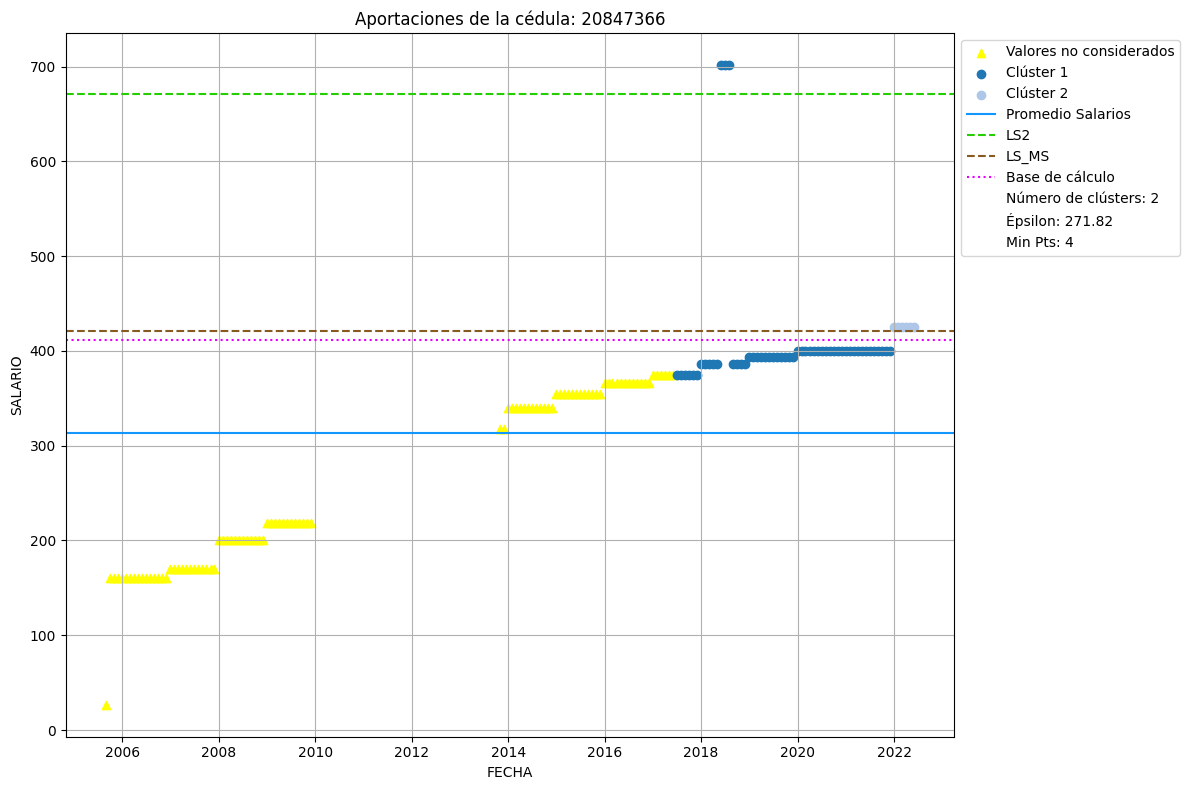

In [34]:
cedul = 20847366
#graf_dbscan(data_l , cedul, 'SALARIO',  grupo_sel = 0) # 8804, 3071, 20857054, 10133, 20013447, 3608, 135752, 154409, 1908, 20847366
graf_dbscan_guardar(data_l , cedul, 'SALARIO',  grupo_sel = 0, caso=1)

In [36]:
val = ['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'SALARIO_SECTOR', 'SECTOR_A',
       'NUM_SEC_MES', '%_NUM_SECTOR', 'GRUPO', 'SAL_PROM_GRUPO', 'GRUPO_SEL',
       'INI_CAL', 'FIN_CAL', 'BASE_CAL', 'SBU', 'ID_SBU', 'INDICE', 'ATI_DB', 'LS1',
       'SAL_PROM1', 'LS2', 'SAL_PROM2', 'LS_MS']

data_l1 = data_l[val]

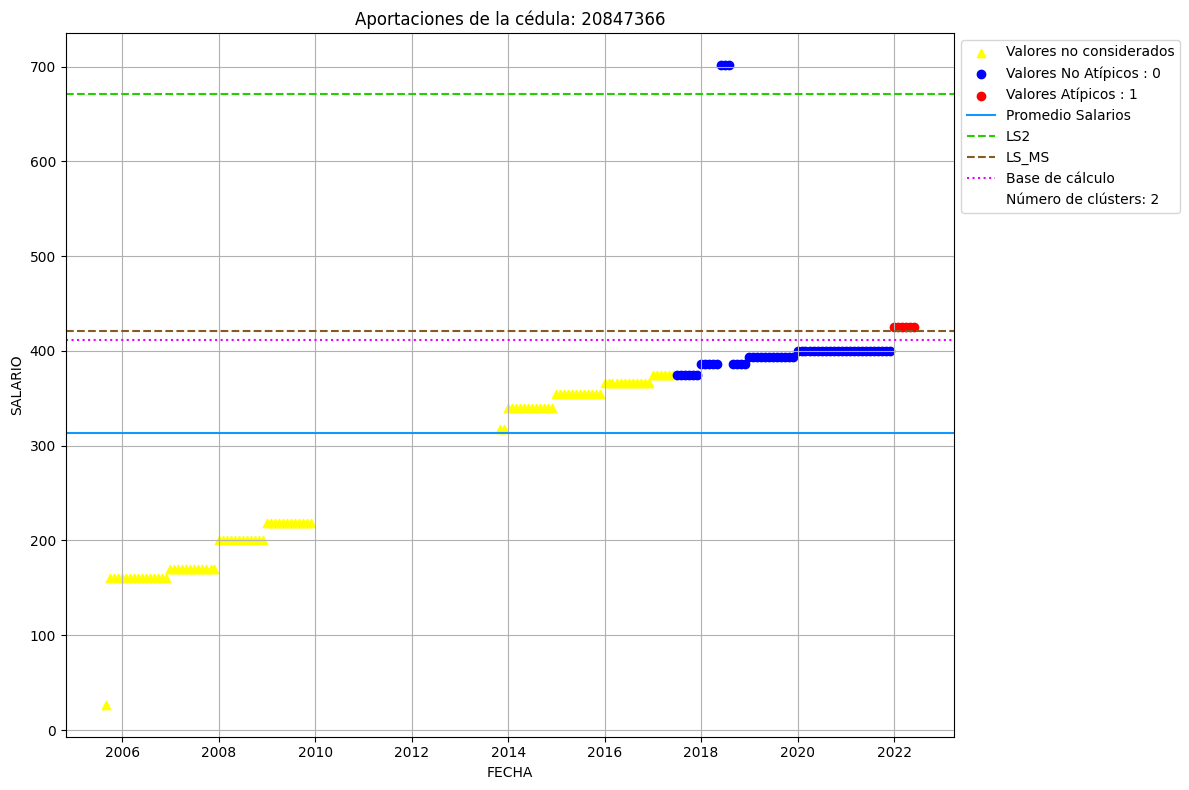

In [47]:
cedul = 20847366
#graf_DB(data_l1 , cedul, 'SALARIO',  grupo_sel = 0) #8804, 3071, 20857054, 10133, 20013447, 3608, 135752, 154409, 1908, 20847366
graf_DB_guardar(data_l1 , cedul, 'SALARIO',  grupo_sel = 0, caso=1)

In [18]:
grouped = data_l['CEDULA_COD'].drop_duplicates().sample(n=30000, random_state=1)
muestra = data_l[data_l['CEDULA_COD'].isin(grouped)]
muestra.to_csv('muestra_db.txt', sep='\t', index=False)# Agrupar por CEDULA_COD

In [ ]:
val=[]
data_l[(data_l['CEDULA_COD']==13603) & (data_l['GRUPO_SEL']==1) & (data_l['SALARIO'] < data_l[['LS2', 'LS_MS']].min(axis=1) ) ]

In [ ]:
    data_l['ATI_DB'].max(skipna=True)